In [12]:
!pip install --upgrade oci

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 33.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: oci
    Found existing installation: oci 2.81.0
    Uninstalling oci-2.81.0:
      Successfully uninstalled oci-2.81.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
oci-cli 3.16.0 requires oci==2.81.0, but you have oci 2.93.0 which is incompatible.


# OCI Data Pipeline Demo: PoC 코드

## 00. 현재 진행 상태

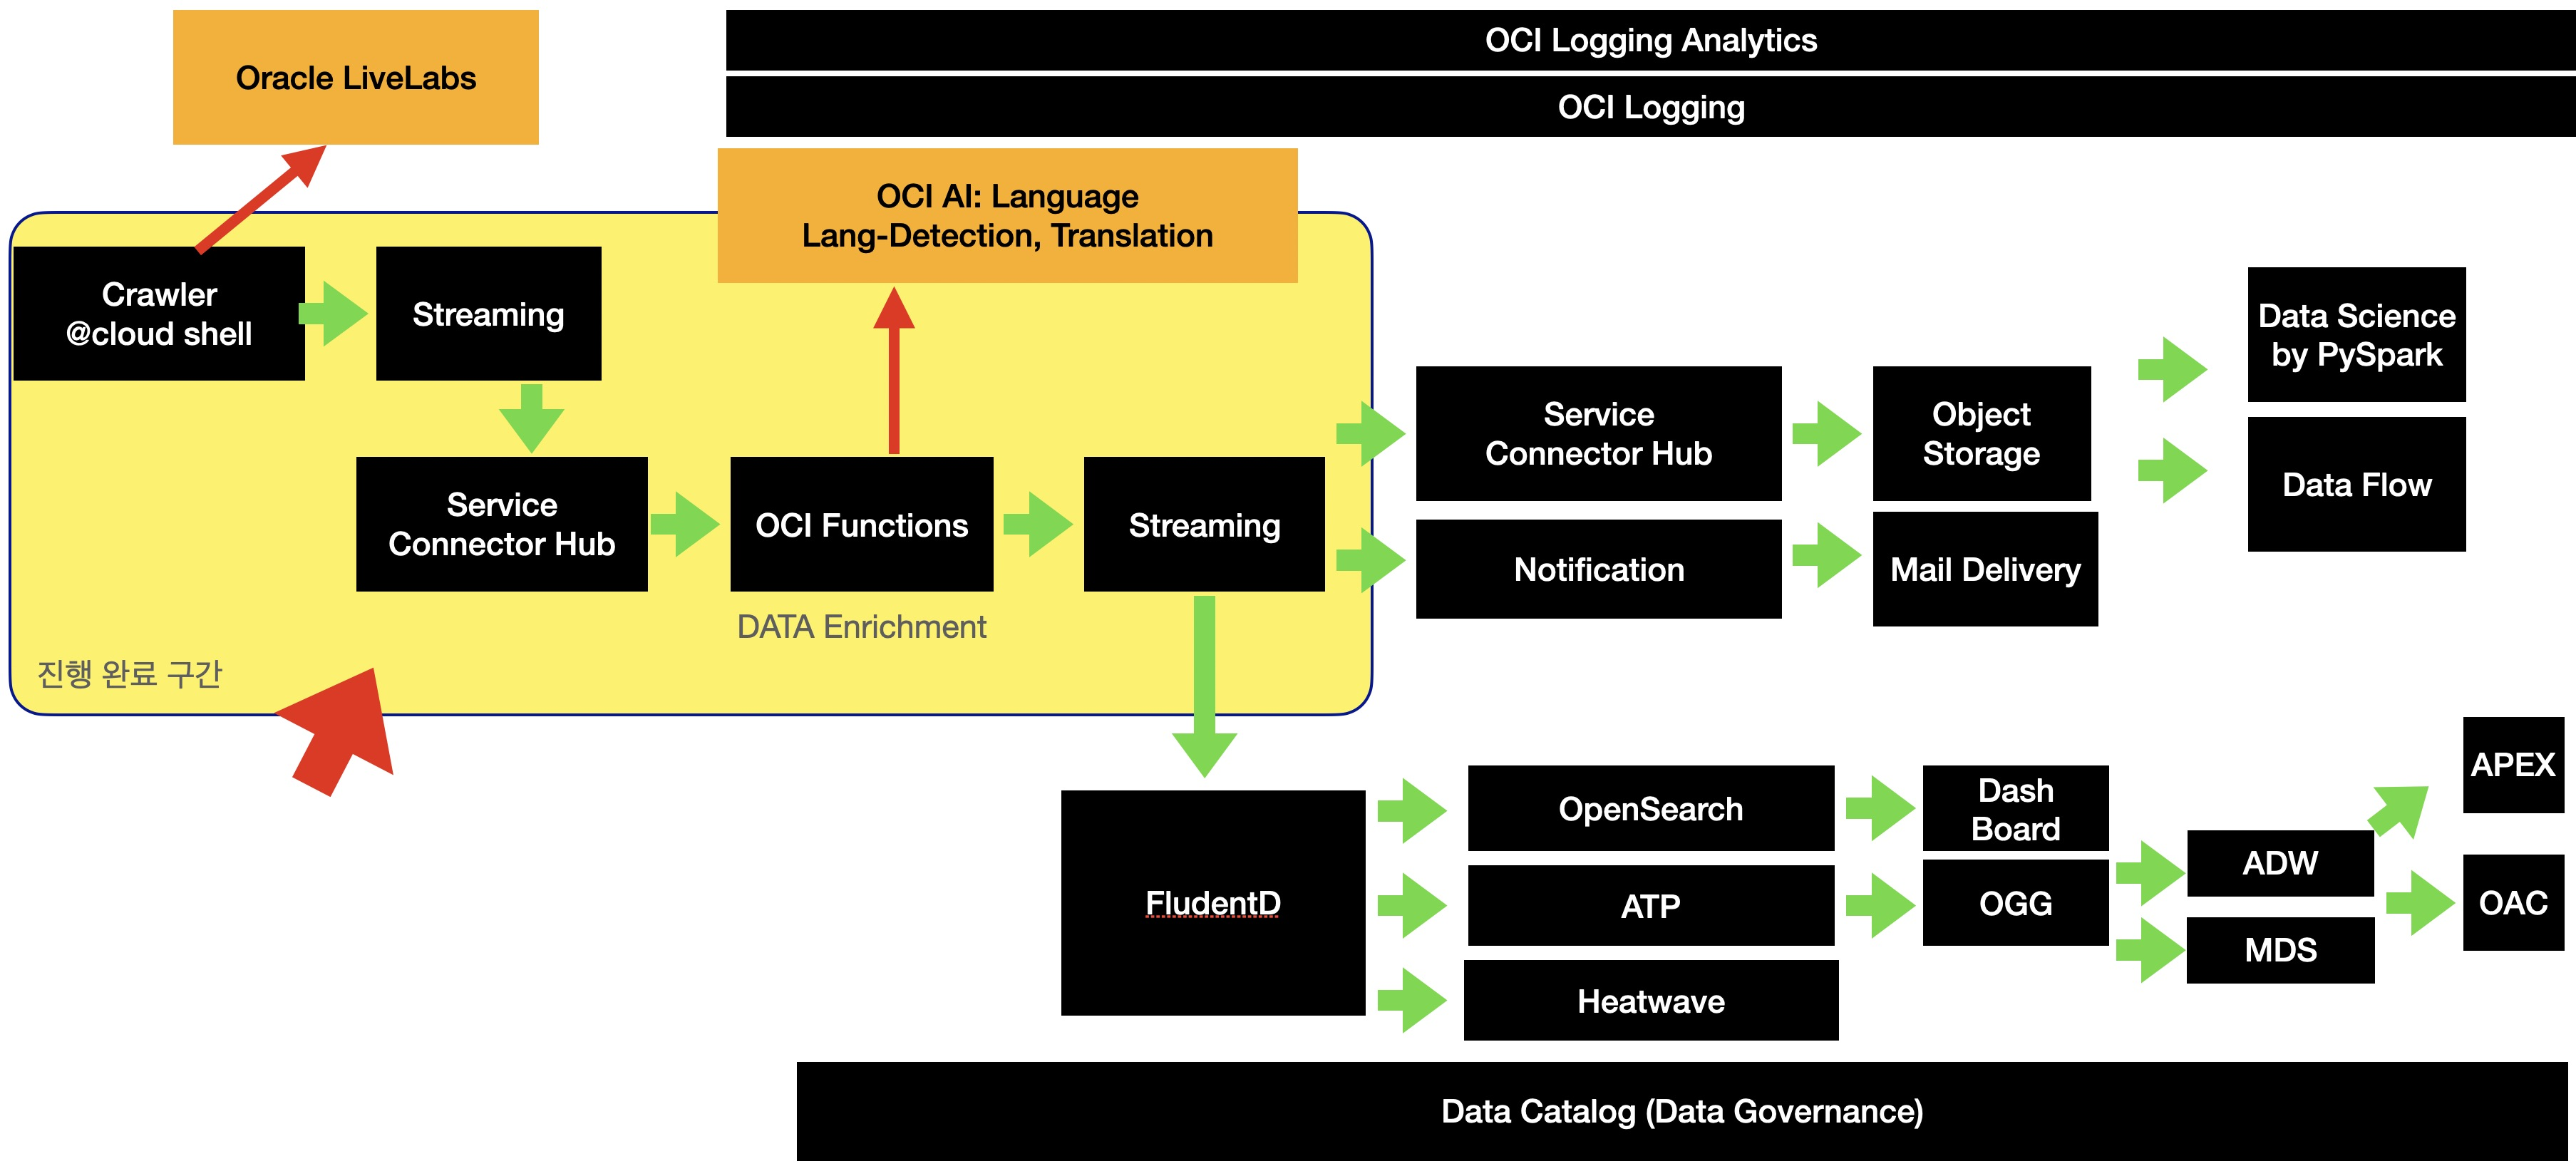

In [538]:
Image(filename='./images/fig09.jpg')

## 01. LiveLab 크롤링 코드

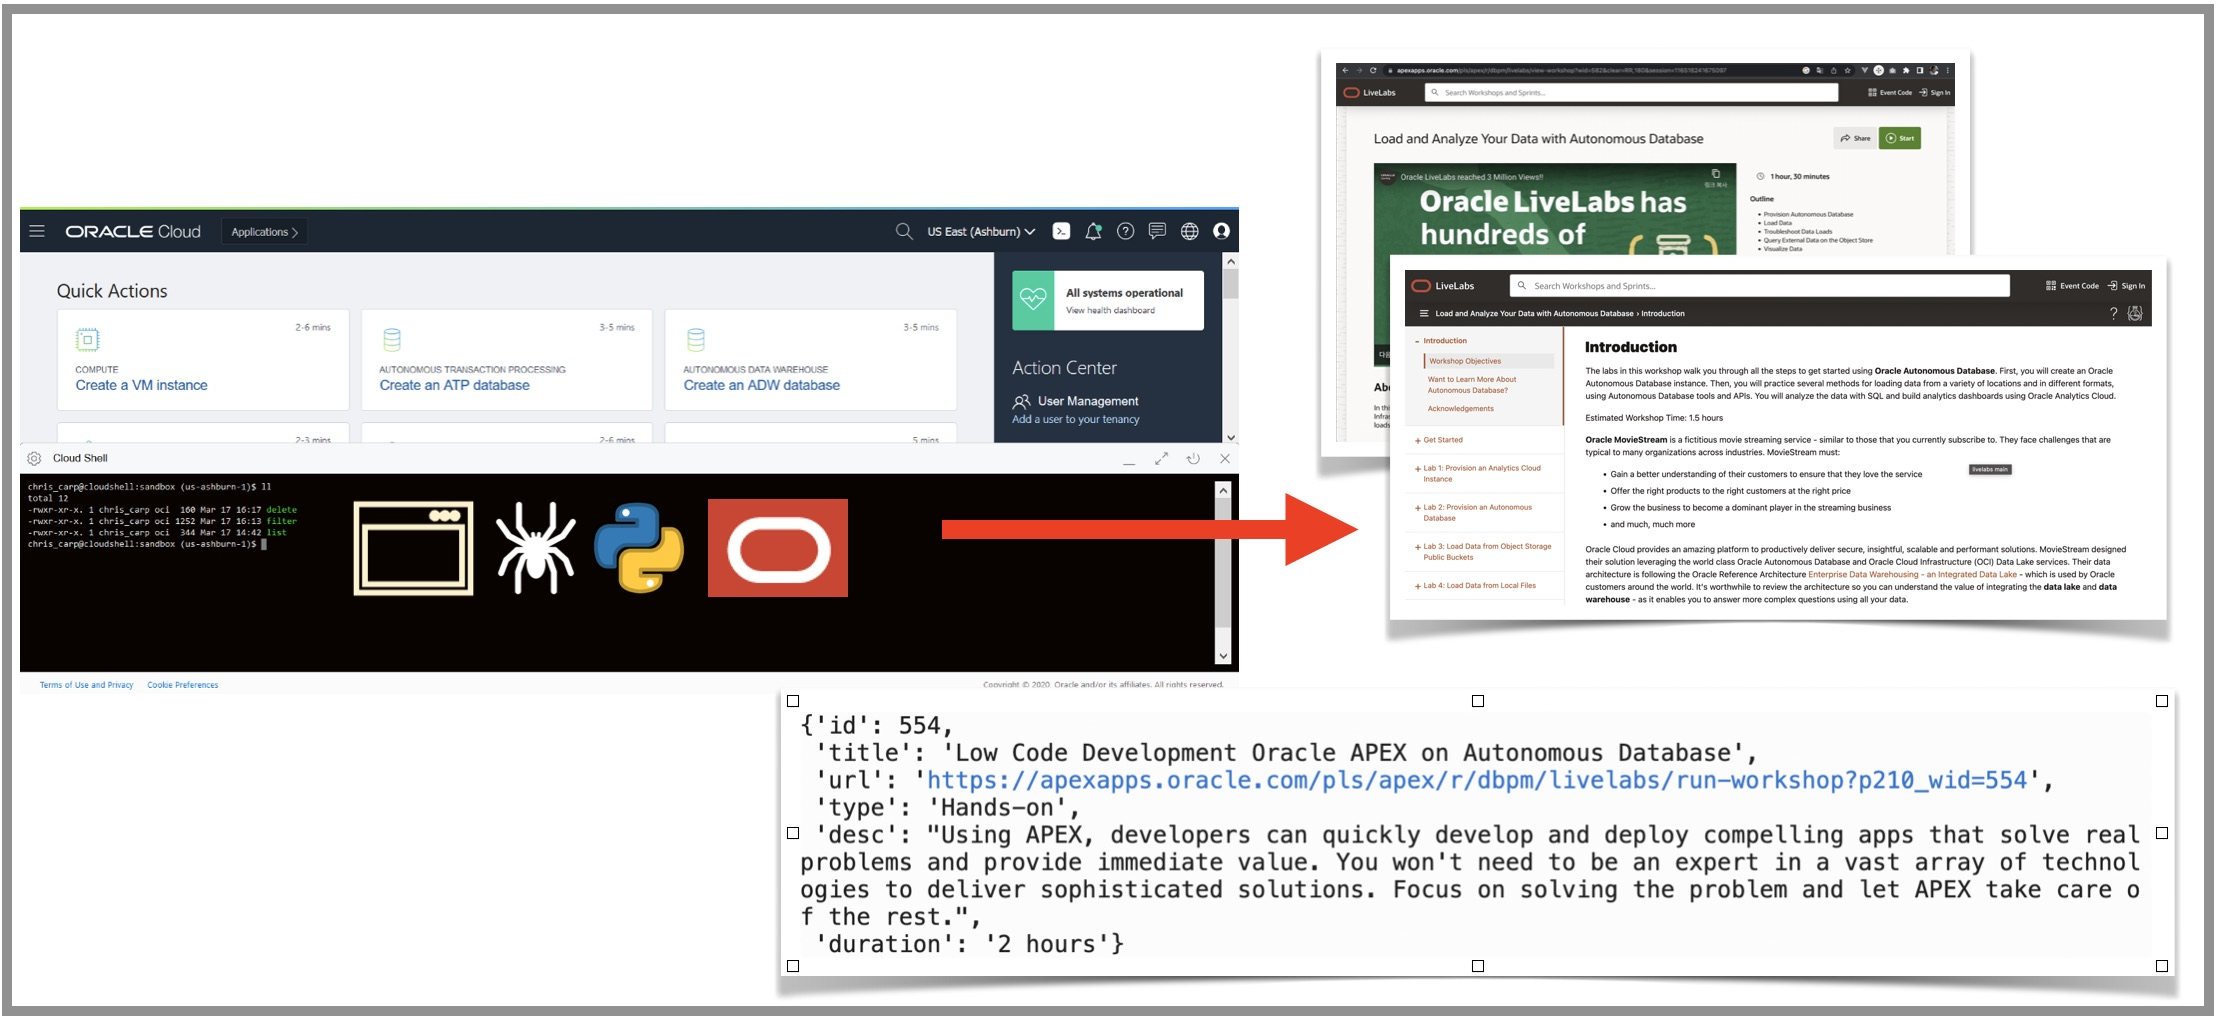

In [321]:
from IPython.display import Image
Image(filename='./images/fig01.jpg')

In [267]:
import datetime
from bs4 import BeautifulSoup
import urllib.request
import requests 
import oci

In [268]:
oci.__version__

'2.88.0'

In [269]:
def get_livelab(id):
    base_url="https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/view-workshop?wid="+str(id)
    
    base_res = requests.get(base_url) 
    base_soup = BeautifulSoup(base_res.text, "html.parser")
    title = base_soup.title.string
    if title.strip() =='LiveLabs Home':
        return None
    
    data = {}
    data['id']=id
    data['title']=title
    
    main_url = "https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid="+str(i)
    data['url'] = main_url
    
    main_res = requests.get(main_url) 
    main_soup = BeautifulSoup(main_res.text, "html.parser")
    
    if abs(len(main_res.text)-len(base_res.text)) < 100 :
        data['type'] = 'Sprint'
        data['duration'] = '10 Minutes'
    else:
        data['type'] = 'Hands-on'
        
    if data['type']=='Hands-on':
        data['desc'] = base_soup.select_one("#P180_DESC_LONG").text
        data['duration'] = base_soup.select_one("#P180_WORKSHOP_TIME").text
    
    return data

## 02. 크롤링 기본 구조

In [270]:
docs = []
for i in range(550, 555):
    data = get_livelab(i)
    if data != None:
        print(data)
        docs.append(data)

{'id': 553, 'title': 'Manage and Monitor Autonomous Database', 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=553', 'type': 'Hands-on', 'desc': 'The labs in this workshop show you a variety of ways to manage and monitor your Oracle Autonomous Database on Shared Infrastructure (ADB-S). You will provision a new ADB instance, practice connecting to the database securely with and without a connection wallet, examine a variety of ways to monitor database performance and other metrics, apply scaling and auto scaling, enable disaster recovery using Autonomous Data Guard, create refreshable database clones, set event and alarm notifications, and secure your data using Oracle Data Safe.', 'duration': '3 hours'}
{'id': 554, 'title': 'Low Code Development Oracle APEX on Autonomous Database', 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=554', 'type': 'Hands-on', 'desc': "Using APEX, developers can quickly develop and deploy 

## 03. 스트림 저장 (Producing data to Stream)

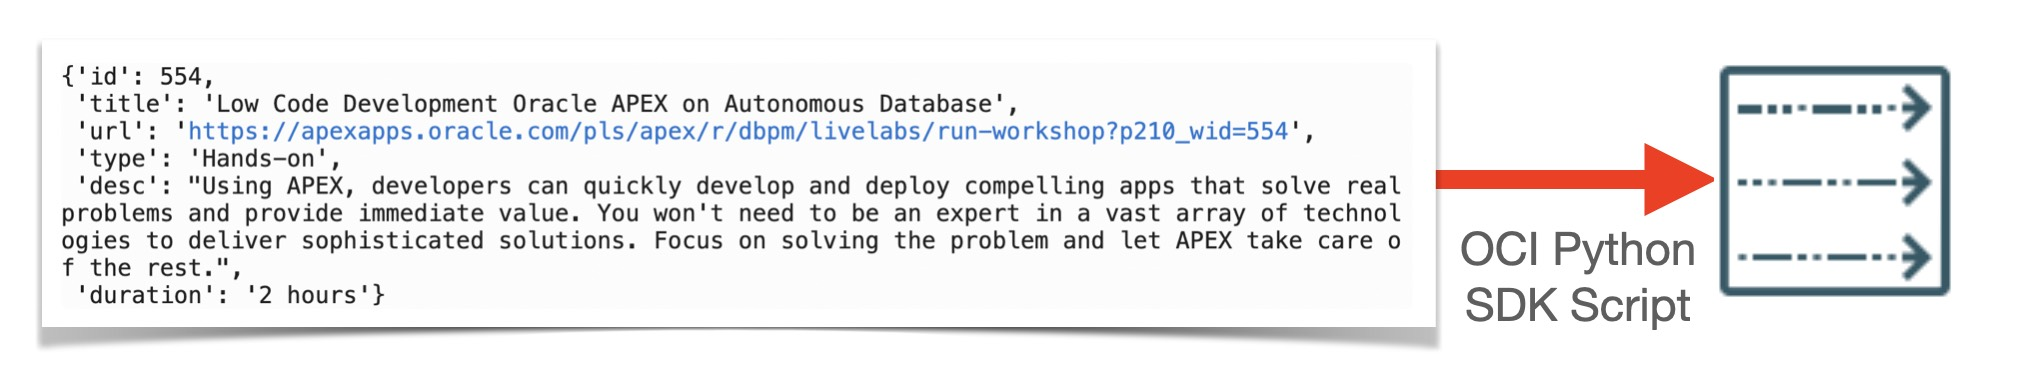

In [322]:
Image(filename='./images/fig02.jpg')

In [271]:
STREAM_NAME='crawling_stream'
STREAM_OCID='ocid1.stream.oc1.ap-tokyo-1.amaaaaaavsea7yiaxsqfbklai5qjjvkqgi723akoaaascgu7yyoeee7hvgla'
MESSAGE_ENDPOINT='https://cell-1.streaming.ap-tokyo-1.oci.oraclecloud.com'

In [298]:
import oci  
  
from base64 import b64encode  
from json import dumps
  
def produce_messages(json_str, client, stream_id):
  message_list = []

  encoded_value =b64encode(json_str.encode()).decode()

  message_list.append(oci.streaming.models.PutMessagesDetailsEntry(value = encoded_value))  
  
  #print("Publishing {} messages to the stream {} ".format(len(message_list), stream_id))
  messages = oci.streaming.models.PutMessagesDetails(messages=message_list)
  put_message_result = client.put_messages(stream_id, messages)
  
  for entry in put_message_result.data.entries:
      if entry.error:
          print("Error ({}) : {}".format(entry.error, entry.error_message))
      #else:
          #print("Published message to partition {} , offset {}".format(entry.partition, entry.offset))

In [288]:
config = oci.config.from_file()
stream_client = oci.streaming.StreamClient(config, service_endpoint=MESSAGE_ENDPOINT)

for doc in docs:
    produce_messages(json.dumps(doc), stream_client, STREAM_OCID)

Publishing 1 messages to the stream ocid1.stream.oc1.ap-tokyo-1.amaaaaaavsea7yiaxsqfbklai5qjjvkqgi723akoaaascgu7yyoeee7hvgla 
Published message to partition 1 , offset 193
Publishing 1 messages to the stream ocid1.stream.oc1.ap-tokyo-1.amaaaaaavsea7yiaxsqfbklai5qjjvkqgi723akoaaascgu7yyoeee7hvgla 
Published message to partition 0 , offset 156


## 04. Stream 메시지 읽기

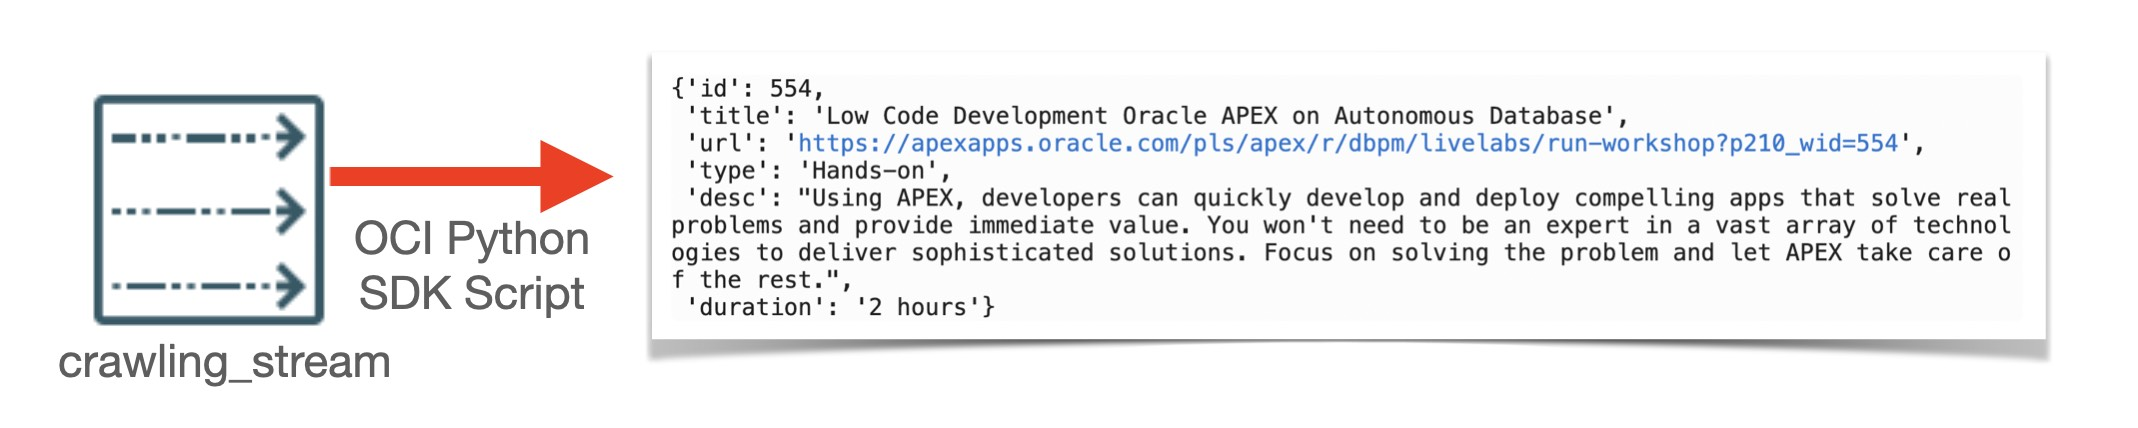

In [323]:
Image(filename='./images/fig03.jpg')

In [289]:
import oci
import time

from base64 import b64decode 
from json import loads


def get_cursor_by_group(sc, sid, group_name, instance_name):
    print(" Creating a cursor for group {}, instance {}".
          format(group_name, instance_name))
    cursor_details = oci.streaming.models.CreateGroupCursorDetails
        (group_name=group_name, instance_name=instance_name,
            type=oci.streaming.models.
            CreateGroupCursorDetails.TYPE_LATEST,
            commit_on_get=True)
    response = sc.create_group_cursor(sid, cursor_details)
    return response.data.value

def simple_message_loop(client, stream_id, initial_cursor):
    cursor = initial_cursor
    while True:
        get_response = client.get_messages(stream_id, cursor, limit=10)
        # No messages to process. return.
        if not get_response.data:
            return

        # Process the messages
        print("Read {} messages".format(len(get_response.data)))
        for message in get_response.data:
            if message.key is None:
                key = "Null"
            else:
                key = b64decode(message.key.encode()).decode()

            decoded_message = b64decode(message.value.encode()).decode()
            doc = loads(decoded_message)
            print(doc)
            

        # get_messages is a throttled method; clients should retrieve sufficiently large message
        # batches, as to avoid too many http requests.
        time.sleep(1)
        # use the next-cursor for iteration
        cursor = get_response.headers["opc-next-cursor"]

In [290]:
config = oci.config.from_file()
stream_client = oci.streaming.StreamClient(config, service_endpoint=MESSAGE_ENDPOINT)
group_cursor = get_cursor_by_group(stream_client, STREAM_OCID, "example-group1", "example-instance-1")
simple_message_loop(stream_client, STREAM_OCID, group_cursor)

 Creating a cursor for group example-group1, instance example-instance-1
 Read 1 messages
{'id': 554, 'title': 'Low Code Development Oracle APEX on Autonomous Database', 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=554', 'type': 'Hands-on', 'desc': "Using APEX, developers can quickly develop and deploy compelling apps that solve real problems and provide immediate value. You won't need to be an expert in a vast array of technologies to deliver sophisticated solutions. Focus on solving the problem and let APEX take care of the rest.", 'duration': '2 hours'}
 Read 1 messages
{'id': 553, 'title': 'Manage and Monitor Autonomous Database', 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=553', 'type': 'Hands-on', 'desc': 'The labs in this workshop show you a variety of ways to manage and monitor your Oracle Autonomous Database on Shared Infrastructure (ADB-S). You will provision a new ADB instance, practice connecting t

## 05. send Crawled-Data to Stream

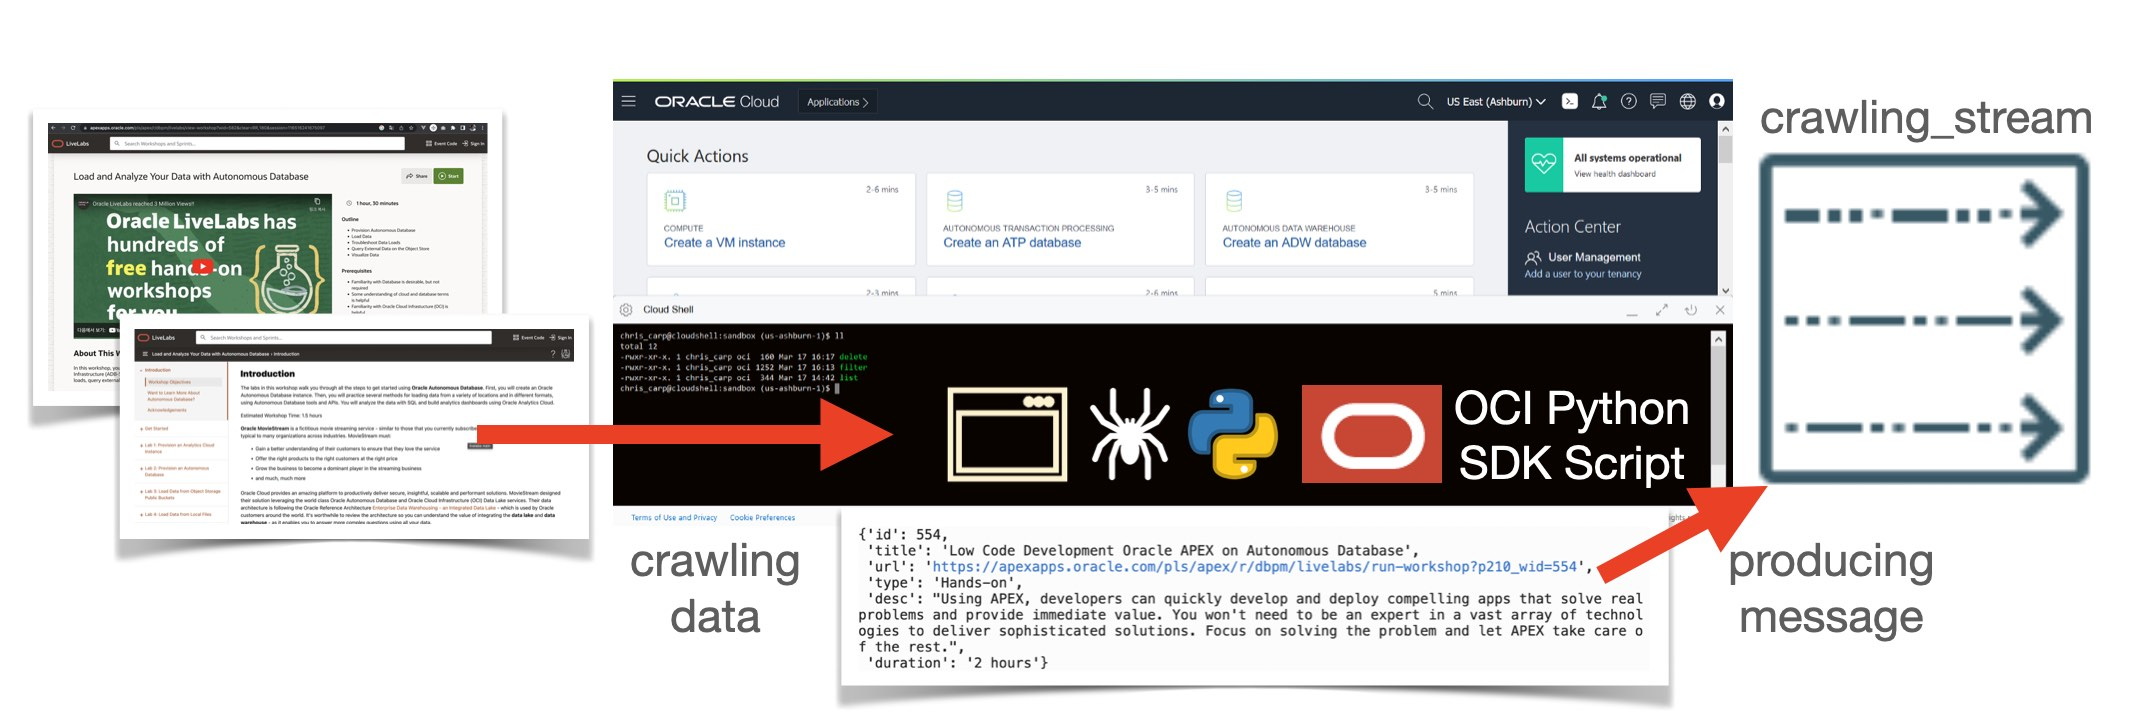

In [324]:
Image(filename='./images/fig04.jpg')

In [299]:
STREAM_NAME='crawling_stream'
STREAM_OCID='ocid1.stream.oc1.ap-tokyo-1.amaaaaaavsea7yiaxsqfbklai5qjjvkqgi723akoaaascgu7yyoeee7hvgla'
MESSAGE_ENDPOINT='https://cell-1.streaming.ap-tokyo-1.oci.oraclecloud.com'

def send_crawled_data_to_stream(id):
    data = get_livelab(id)
    if data != None:    
        config = oci.config.from_file()
        stream_client = oci.streaming.StreamClient(config, service_endpoint=MESSAGE_ENDPOINT)
        produce_messages(json.dumps(data), stream_client, STREAM_OCID)
        print(data)
    

In [300]:
docs = []
for i in range(550, 600):
    send_crawled_data_to_stream(i)

print("Producing {} messages".format(len(docs)))

{'id': 553, 'title': 'Manage and Monitor Autonomous Database', 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=553', 'type': 'Hands-on', 'desc': 'The labs in this workshop show you a variety of ways to manage and monitor your Oracle Autonomous Database on Shared Infrastructure (ADB-S). You will provision a new ADB instance, practice connecting to the database securely with and without a connection wallet, examine a variety of ways to monitor database performance and other metrics, apply scaling and auto scaling, enable disaster recovery using Autonomous Data Guard, create refreshable database clones, set event and alarm notifications, and secure your data using Oracle Data Safe.', 'duration': '3 hours'}
{'id': 554, 'title': 'Low Code Development Oracle APEX on Autonomous Database', 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=554', 'type': 'Hands-on', 'desc': "Using APEX, developers can quickly develop and deploy 

### 05.01 스트림 저장 데이터 확인

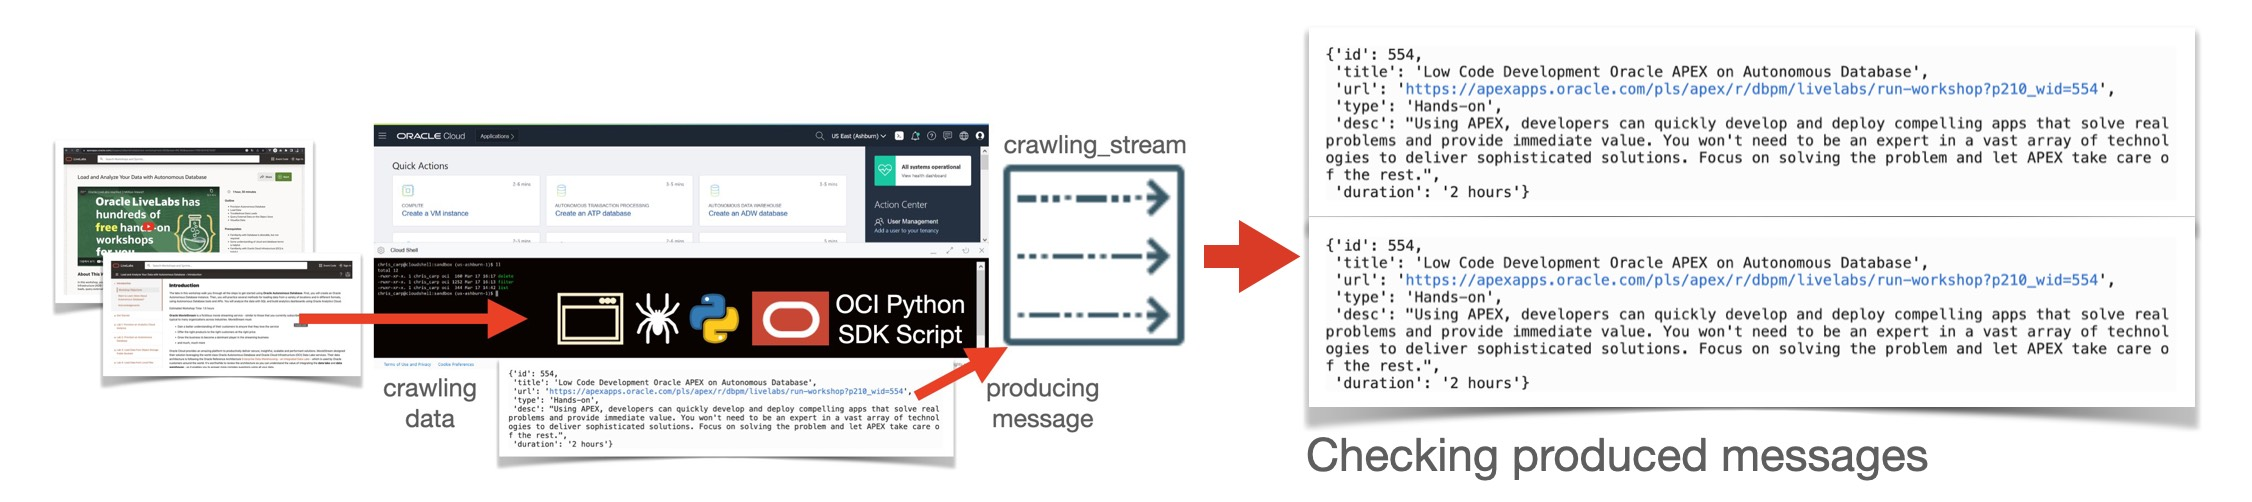

In [325]:
Image(filename='./images/fig05.jpg')

In [301]:
config = oci.config.from_file()
stream_client = oci.streaming.StreamClient(config, service_endpoint=MESSAGE_ENDPOINT)
group_cursor = get_cursor_by_group(stream_client, STREAM_OCID, "example-group1", "example-instance-1")
simple_message_loop(stream_client, STREAM_OCID, group_cursor)

 Creating a cursor for group example-group1, instance example-instance-1
 Read 3 messages
{'id': 554, 'title': 'Low Code Development Oracle APEX on Autonomous Database', 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=554', 'type': 'Hands-on', 'desc': "Using APEX, developers can quickly develop and deploy compelling apps that solve real problems and provide immediate value. You won't need to be an expert in a vast array of technologies to deliver sophisticated solutions. Focus on solving the problem and let APEX take care of the rest.", 'duration': '2 hours'}
{'id': 560, 'title': 'Machine Learning on Autonomous Database', 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=560', 'type': 'Hands-on', 'desc': 'Oracle integrates machine learning across the Oracle stack and the enterprise, fully leveraging Oracle Database and Oracle Autonomous Database.  In this workshop, create a machine learning model and move the model to 

## 06. 크롤링 데이터 확장 (Feat. AI Language Service)

In [357]:
def detect_language(src_text):
    ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file())    
    batch_language_detection_details =  oci.ai_language.models.DetectDominantLanguageDetails(text=src_text)
    output = ai_client.detect_dominant_language(batch_language_detection_details)
    
    return output.data.languages[0].code

### 06-01. 언어 감지 기능 검증

In [358]:
detect_language("동해물과"), detect_language("oracle cloud infrastructure"), detect_language("Oracle クラウド")

('ko', 'en', 'ja')

### 06-02. 크롤링 데이터 한국어 번역 필드 추가

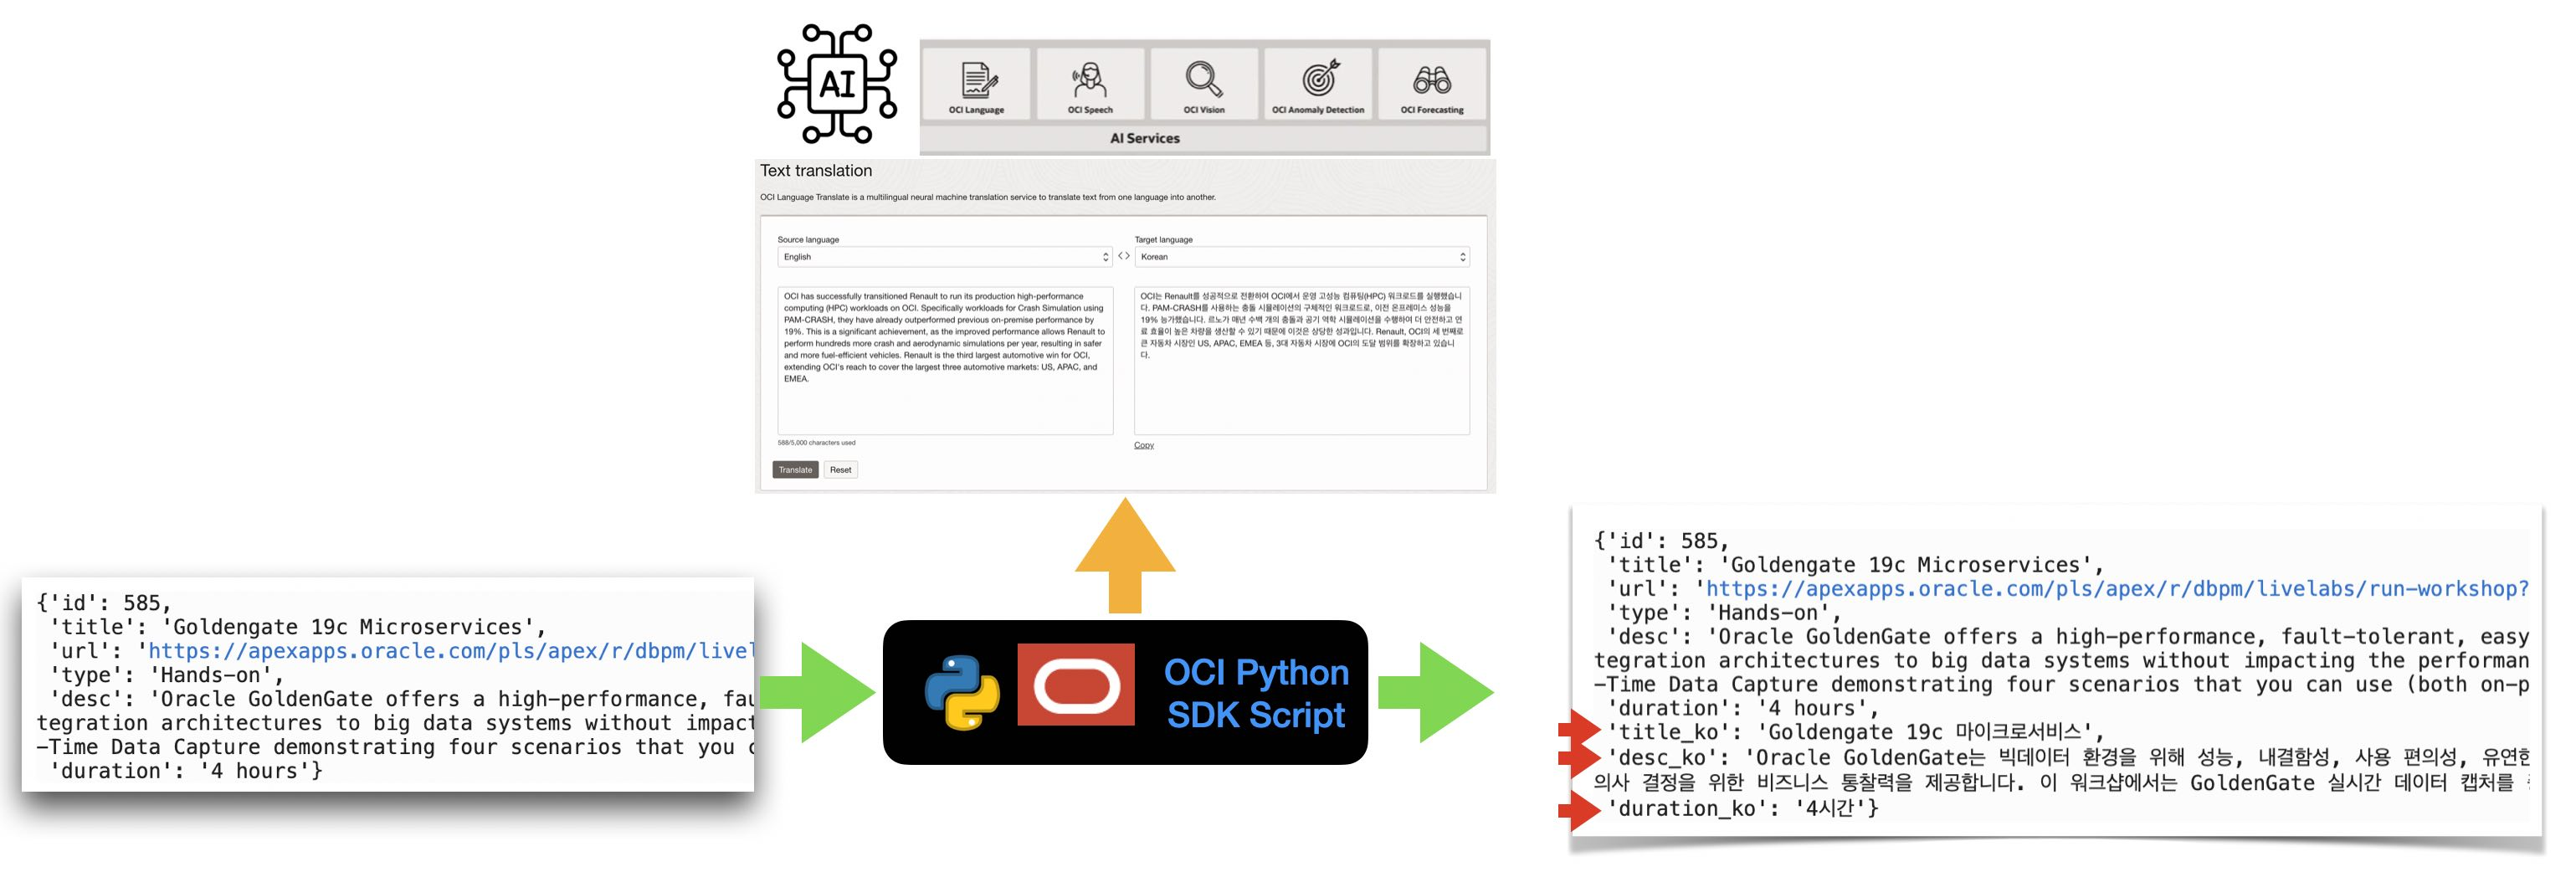

In [412]:
Image(filename='./images/fig06.jpg')

In [451]:
def add_ko_fields_with_crawled_data(crawled_data):
    based_language_code = detect_language(crawled_data["title"])
    
    ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file())
    compartment_ocid='ocid1.compartment.oc1..aaaaaaaahhfxzgr4chrpp7hqeyuksevfw534t5g5igzrnoibu25b625gbnlq'

    docs = []
    doc = oci.ai_language.models.text_document.TextDocument(key='title', text=crawled_data['title'], language_code=based_language_code)
    docs.append(doc)
    
    print(crawled_data['type'])
    if crawled_data['type']=='Hands-on':
        doc = oci.ai_language.models.text_document.TextDocument(key='desc', text=crawled_data['desc'], language_code=based_language_code)
        docs.append(doc)
        doc = oci.ai_language.models.text_document.TextDocument(key='duration', text=crawled_data['duration'], language_code=based_language_code)
        docs.append(doc)    
    
    batch_language_translate_details =  oci.ai_language.models.BatchLanguageTranslationDetails(documents=docs, 
                                    compartment_id=compartment_ocid, target_language_code="ko")
    output = ai_client.batch_language_translation(batch_language_translate_details)
    
    for document in output.data.documents:
        crawled_data[document.key+'_ko']=document.translated_text
    
    return crawled_data
   
    
    

#### 06-02-01. 번역 필드 로직 검증

In [527]:
dummy_crawled_data_str1="""
{"id": 585, "title": "Goldengate 19c Microservices", "url": "https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=585", 
"type": "Hands-on", 
"desc": "Oracle Database In-Memory provides a unique dual-format architecture that enables tables to be simultaneously represented in memory using traditional row format and a new in-memory column format. This series of labs uses Oracle Database 21c to demonstrate how Database In-Memory is orders of magnitude faster than the traditional row store. Labs will show how to get started with Database In-Memory, how to populate and administer the IM column store, and how to run queries including joins and aggregations. It also highlights new features available in Oracle Database 21c that improve the performance of JSON applications and allow the contents of the IM column store to be automatically managed. Oracle GoldenGate offers a high-performance, fault-tolerant, easy-to-use, and flexible real-time data streaming platform for big data environments. It easily extends customers’ real-time data integration architectures to big data systems without impacting the performance of the source systems and enables timely business insight for better decision making. This workshop focuses on GoldenGate Real-Time Data Capture demonstrating four scenarios that you can use (both on-premise and in the cloud) to capture real-time data changes from your sources. Oracle Autonomous Database can use Oracle Cloud Infrastructure Object Store as the location of external tables. In this workshop, you will load data into an Autonomous Database instance using SQL Web Developer, upload files into an Object Store, and use the files as the source of external tables.", 
"duration": "4 hours"}
"""
dummy_data = loads(dummy_crawled_data_str1)
dummy_data

{'id': 585,
 'title': 'Goldengate 19c Microservices',
 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=585',
 'type': 'Hands-on',
 'desc': 'Oracle Database In-Memory provides a unique dual-format architecture that enables tables to be simultaneously represented in memory using traditional row format and a new in-memory column format. This series of labs uses Oracle Database 21c to demonstrate how Database In-Memory is orders of magnitude faster than the traditional row store. Labs will show how to get started with Database In-Memory, how to populate and administer the IM column store, and how to run queries including joins and aggregations. It also highlights new features available in Oracle Database 21c that improve the performance of JSON applications and allow the contents of the IM column store to be automatically managed. Oracle GoldenGate offers a high-performance, fault-tolerant, easy-to-use, and flexible real-time data streaming platform for b

In [528]:
add_ko_fields_with_crawled_data(dummy_data)

Hands-on


{'id': 585,
 'title': 'Goldengate 19c Microservices',
 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=585',
 'type': 'Hands-on',
 'desc': 'Oracle Database In-Memory provides a unique dual-format architecture that enables tables to be simultaneously represented in memory using traditional row format and a new in-memory column format. This series of labs uses Oracle Database 21c to demonstrate how Database In-Memory is orders of magnitude faster than the traditional row store. Labs will show how to get started with Database In-Memory, how to populate and administer the IM column store, and how to run queries including joins and aggregations. It also highlights new features available in Oracle Database 21c that improve the performance of JSON applications and allow the contents of the IM column store to be automatically managed. Oracle GoldenGate offers a high-performance, fault-tolerant, easy-to-use, and flexible real-time data streaming platform for b

In [529]:
dummy_crawled_data_str2="""
{"id": 585, "title": "Goldengate 19c Microservices", "url": "https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=585", 
"type": "Sprint"}
"""
dummy_data2 = loads(dummy_crawled_data_str2)
dummy_data2

{'id': 585,
 'title': 'Goldengate 19c Microservices',
 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=585',
 'type': 'Sprint'}

In [530]:
add_ko_fields_with_crawled_data(dummy_data2)

Sprint


{'id': 585,
 'title': 'Goldengate 19c Microservices',
 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=585',
 'type': 'Sprint',
 'title_ko': 'Goldengate 19c 마이크로서비스'}

## 07. 추가 필드 확보 - 제품명/서비스명 추출

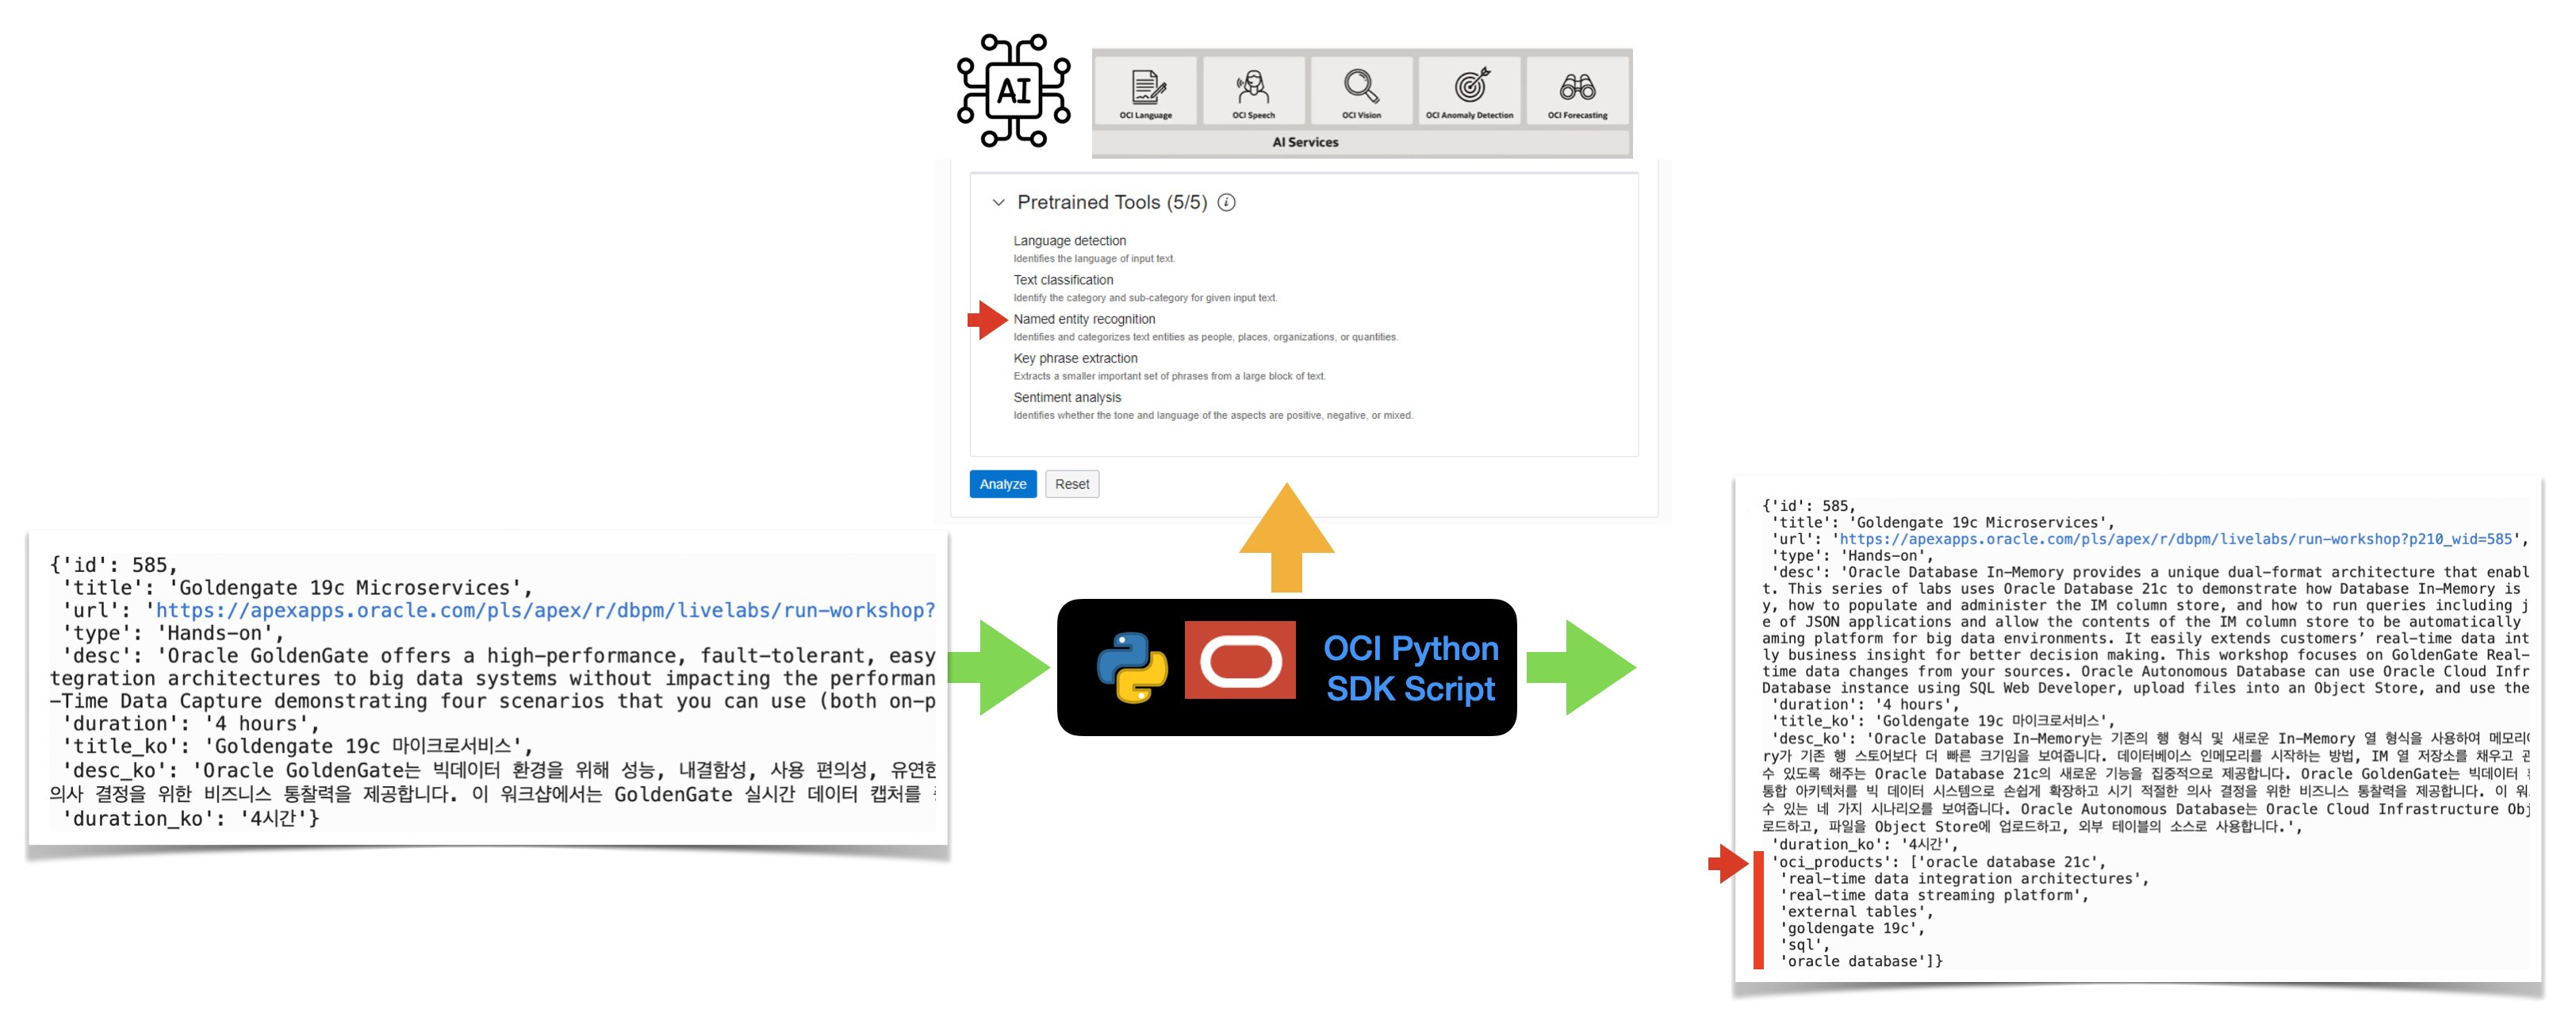

In [533]:
Image(filename='./images/fig07.jpg')

In [531]:
def add_oci_services_field(crawled_data):
    
    new_str = []
    new_str.append(crawled_data['title'])
    if crawled_data['type']=='Hands-on':
        new_str.append(crawled_data['desc'])
        
    new_str = ''.join(new_str)
    
    ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file())
    details = oci.ai_language.models.DetectLanguageEntitiesDetails(text=new_str)
    output = ai_client.detect_language_entities(details)

    oci_services=set()
    for name_entity in output.data.entities:
        if name_entity.type=="PRODUCT" and name_entity.score > 0.8:
            oci_services.add(name_entity.text.lower())
    
    if len(oci_services)>0:
        crawled_data['oci_products']=list(oci_services)
            
    return crawled_data

In [532]:
add_oci_services_field(dummy_data)

{'id': 585,
 'title': 'Goldengate 19c Microservices',
 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=585',
 'type': 'Hands-on',
 'desc': 'Oracle Database In-Memory provides a unique dual-format architecture that enables tables to be simultaneously represented in memory using traditional row format and a new in-memory column format. This series of labs uses Oracle Database 21c to demonstrate how Database In-Memory is orders of magnitude faster than the traditional row store. Labs will show how to get started with Database In-Memory, how to populate and administer the IM column store, and how to run queries including joins and aggregations. It also highlights new features available in Oracle Database 21c that improve the performance of JSON applications and allow the contents of the IM column store to be automatically managed. Oracle GoldenGate offers a high-performance, fault-tolerant, easy-to-use, and flexible real-time data streaming platform for b

## 08. 추가 필드 확보 - 키워드 추출

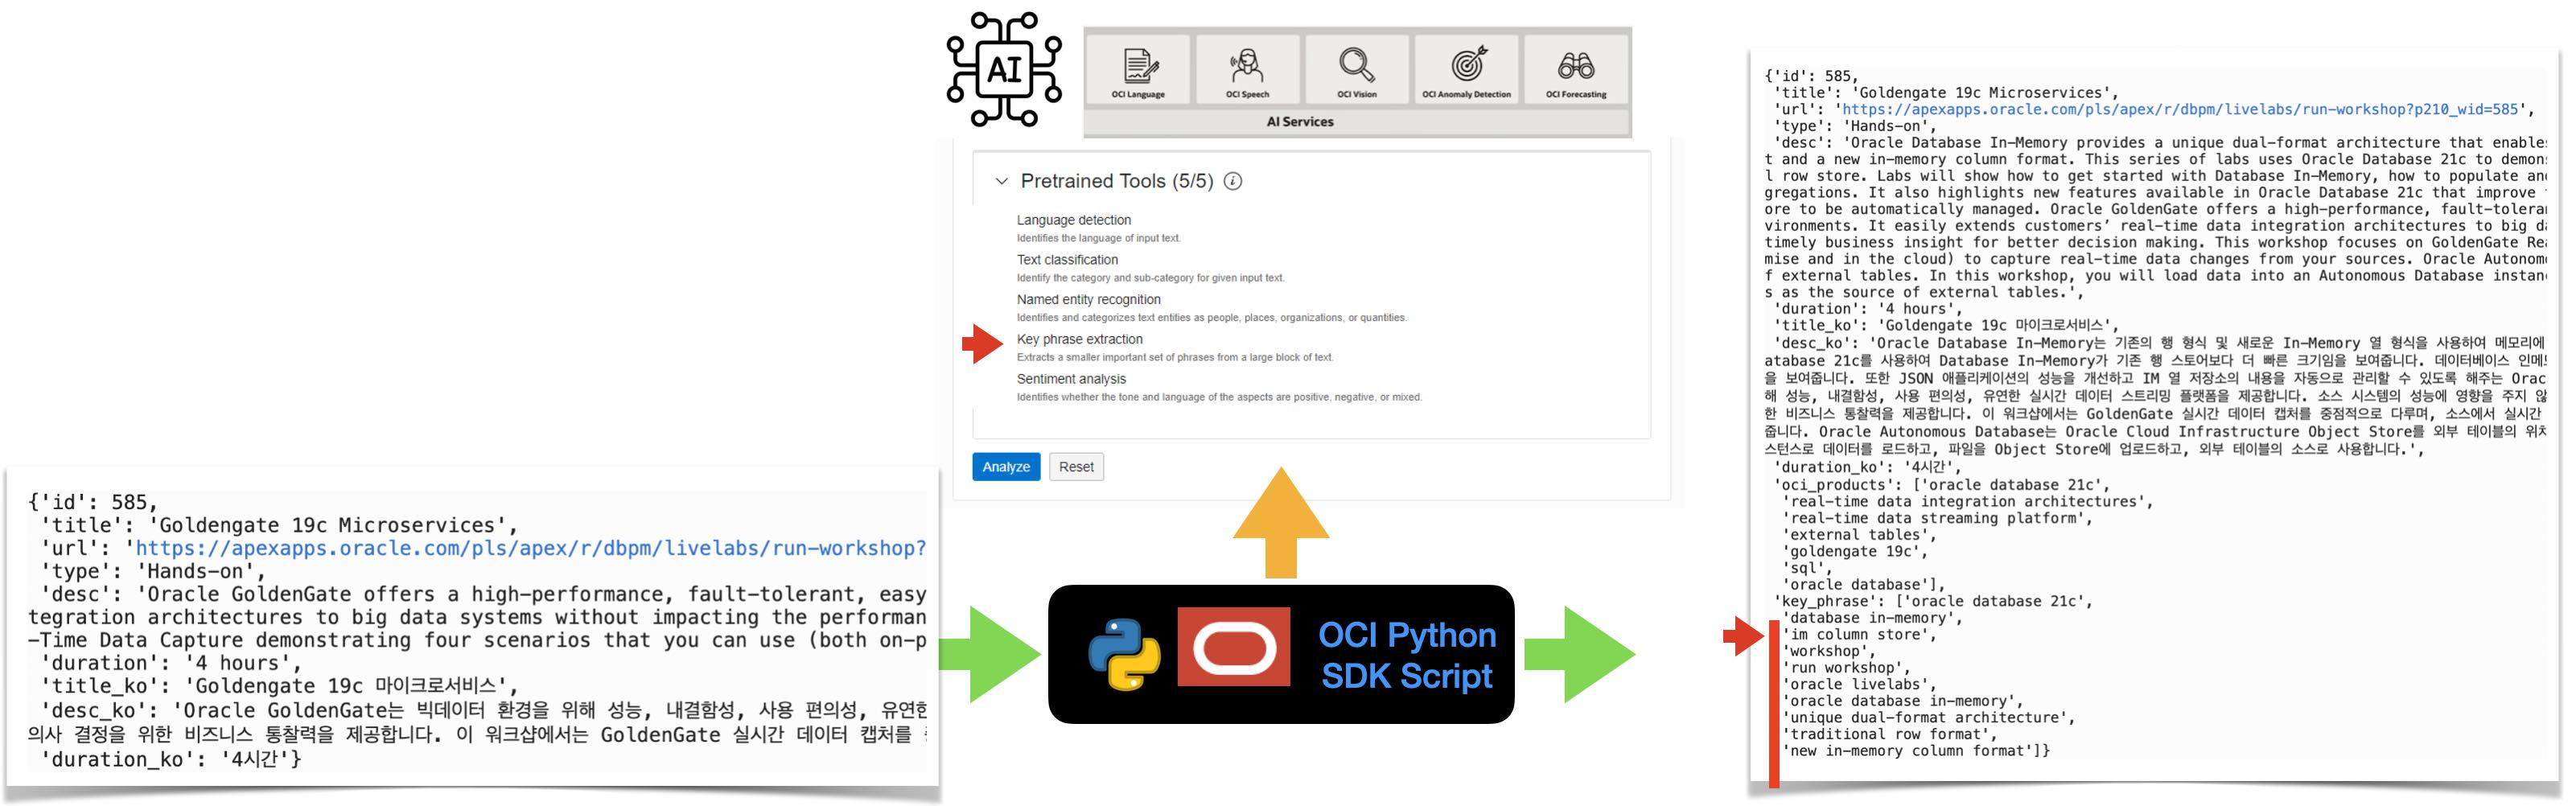

In [536]:
Image(filename='./images/fig08.jpg')

In [534]:
def add_key_phrase_field(crawled_data):
    
    new_str = []
    new_str.append(title)
    
    if crawled_data['type']=='Hands-on':
        new_str.append(crawled_data['desc'])
    
    new_str = ''.join(new_str)
    
    ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file())
    details = oci.ai_language.models.DetectLanguageKeyPhrasesDetails(text=new_str)
    output = ai_client.detect_language_key_phrases(details)

    key_phrase_list=[]
    for key_phrase in output.data.key_phrases:
        if key_phrase.score > 0.99:
            key_phrase_list.append(key_phrase.text)
    
    if len(key_phrase_list)>0:
        return_index = min(10, len(key_phrase_list))
        crawled_data['key_phrase']=key_phrase_list[:return_index]

    return crawled_data

In [535]:
add_key_phrase_field(dummy_data)

{'id': 585,
 'title': 'Goldengate 19c Microservices',
 'url': 'https://apexapps.oracle.com/pls/apex/r/dbpm/livelabs/run-workshop?p210_wid=585',
 'type': 'Hands-on',
 'desc': 'Oracle Database In-Memory provides a unique dual-format architecture that enables tables to be simultaneously represented in memory using traditional row format and a new in-memory column format. This series of labs uses Oracle Database 21c to demonstrate how Database In-Memory is orders of magnitude faster than the traditional row store. Labs will show how to get started with Database In-Memory, how to populate and administer the IM column store, and how to run queries including joins and aggregations. It also highlights new features available in Oracle Database 21c that improve the performance of JSON applications and allow the contents of the IM column store to be automatically managed. Oracle GoldenGate offers a high-performance, fault-tolerant, easy-to-use, and flexible real-time data streaming platform for b